### Imports

In [1]:
import torch
import os
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.gridspec as gridspec

from tqdm.notebook import tqdm
import importlib
from pathlib import Path

# Custom functions and classes
from auxillary.yolo_code_that_we_use import *
from auxillary.confusion_matrix_class import ConfusionMatrix

# import auxillary.mapping; importlib.reload(auxillary.mapping) # reload changes in mapping.py
from auxillary.mapping import HomographyMapping

# import auxillary.detection; importlib.reload(auxillary.detection) # reload changes in detection.py
from auxillary.detection import get_label,compare_post_process,load_dataset,load_detection_model,get_detection,plot_bboxes

# import auxillary.RL_usedirectly; importlib.reload(auxillary.RL_usedirectly) # reload changes in RL_usedirectly.py
from auxillary.RL_usedirectly import load_RL_no_env

2025-06-16 11:15:48.724477: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Table of Contents

This notebook demonstrates the project "pix2pockets" and has 5 main sections:
1. Load the Pool dataset from roboflow
1. Run the full pipeline for an image
1. All functions and plotting
    - Detections
    - Mapping from image to table
    - Doublecam experiment (if applicable)
    - Get RL prediction
1. Run pygame simulation

### Load the Pool dataset from roboflow
Load Roboflow dataset, if it exists. 

To download the dataset, a roboflow API key is required. To initialize this, create the file ```roboflow.json``` including the following line:
```shell
{
    "ROBOFLOW_API_KEY": "Your_api_here"
}
```
Or download it manually using the link found at compute.pix2pockets.dtu.dk

In [2]:
dataset_name = Path('8-Ball-Pool-3')
# folder_type = 'train'
weight_path = Path('detection_model_weight/detection_model.pt')

if not dataset_name.exists(): # only download if dataset does not exist
    import json
    from roboflow import Roboflow

    if not Path('roboflow.json').exists():
        raise FileNotFoundError("Please create a 'roboflow.json' file with your Roboflow API key.")
    
    with open("roboflow.json", "r") as f:
        roboflow_api_key = json.load(f)
    rf = Roboflow(api_key=roboflow_api_key["ROBOFLOW_API_KEY"])
    project = rf.workspace("bachelorthesis").project("8-ball-pool-l530o")
    project.version(3).download("yolov5");

### Run the full pipeline for an image

In [3]:
dataset_name = Path('8-Ball-Pool-3')

model_path = 'detection_model_weight/detection_model.pt'
detection_model = load_detection_model(model_path)

# RL_model_path = 'RL_models/PPO.zip'
RL_model_path = 'Oracle'
RL_model = load_RL_no_env(RL_model_path)

save_folder = Path('plot_export/')

Using cache found in /Users/viktorsebastianpetersen/.cache/torch/hub/ultralytics_yolov5_master
/Users/viktorsebastianpetersen/opt/anaconda3/envs/PoolRL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
YOLOv5 🚀 2025-5-29 Python-3.9.18 torch-2.2.0 CPU

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


ratios: 1565.17 1891.07 0.8277
viewtype: 45VIEW


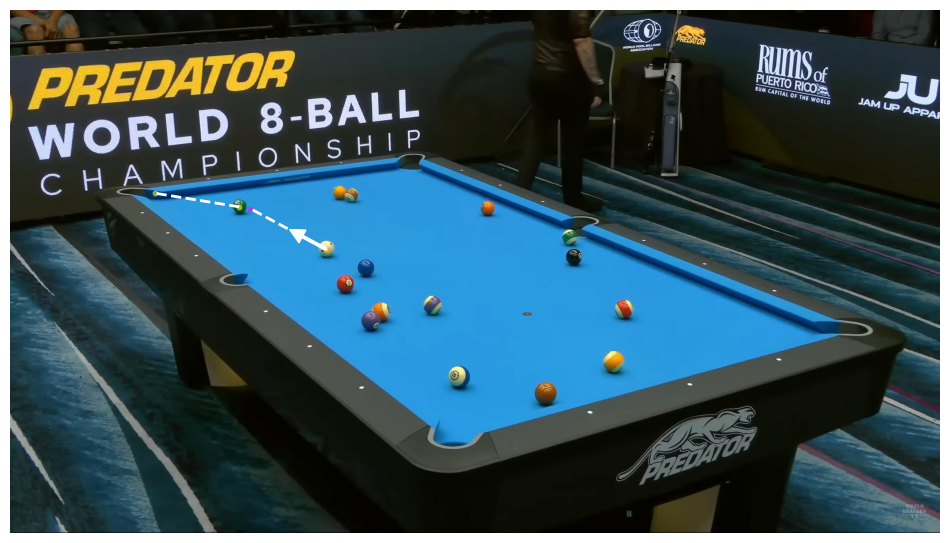

In [4]:
%matplotlib inline

# Put your image path here to use a custom image
image_path = None

# if no image path is given, use the roboflow dataset
if image_path is None: 
    imagenum = 86 # index of the image to use
    datanum = 0 # index of the data to use, if multiple images are available for the same imagenum
    save_folder = save_folder / str(imagenum)
    im_paths, _ = load_dataset(dataset_name, imagenum=imagenum)
    image_path = im_paths[datanum]
save_folder.mkdir(parents=True, exist_ok=True)

# perform detection and prediction
image, detections = get_detection(im_path=image_path, model=detection_model, post_process=True)
Object = HomographyMapping(detections=detections,
                           im=image,
                           savepath=save_folder)
Object.RL_predict(RL_model)
Object.plot_RL_arrow(save=False,plot_warped=False)

# TODO: OBS: When oracle is using mirror hitpoints, the plot still show the straight line

### All functions and plotting

Load model and get detection from images in a folder. These will function as the states for the RL environment.

In [5]:
imagenum = 1 # index of the image to use
datanum = 1  # index of the data to use, if multiple images are available for the same imagenum

save_folder = Path('plot_export/') / str(imagenum)
save_folder.mkdir(parents=True, exist_ok=True)

im_paths, label_paths = load_dataset(dataset_name, imagenum=imagenum)

im_path = im_paths[datanum]
label_path = label_paths[datanum]
if len(im_paths) > 1: 
    print('Doublecam available:',[i.name.split('_')[0] for i in im_paths])
    doublecam=True
else:
    doublecam=False
    print('Doublecam not available')

print('image used: ',im_path.name)
print('labels used:', label_path.name)

# to use your own image, simply set the im_path and label_path to a custom path

Doublecam available: ['1', '1a', '1t']
image used:  1a_png.rf.17bf9820312efff2213b1d1b08ffad66.jpg
labels used: 1a_png.rf.17bf9820312efff2213b1d1b08ffad66.txt


In [6]:
model_path = 'detection_model_weight/detection_model.pt'
detection_model = load_detection_model(model_path)

image, detections = get_detection(im_path=im_path, model=detection_model, post_process=True)

Using cache found in /Users/viktorsebastianpetersen/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2025-5-29 Python-3.9.18 torch-2.2.0 CPU

Fusing layers... 
YOLOv5s_pool summary: 157 layers, 7023610 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


#### Detections

saved to plot_export/1/compare_post_process.png


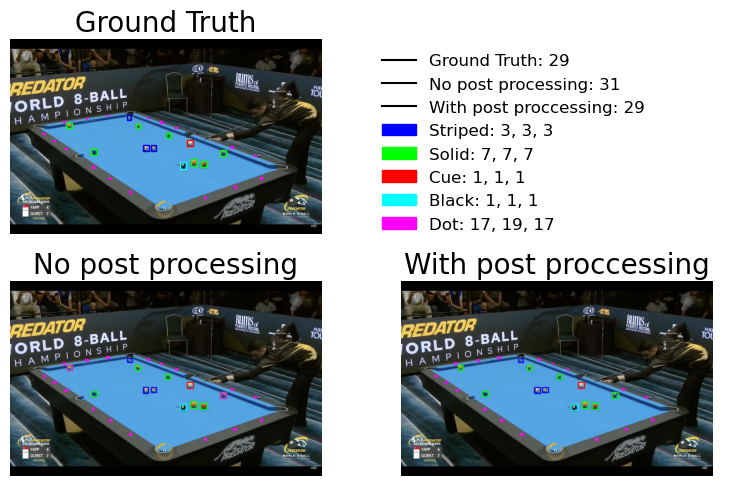

In [7]:
%matplotlib inline

# plot comparison of ground truth and detection (with/without post-processing)

truelabels = get_label(label_path, image.shape[:2])
image_before, detections_before = get_detection(im_path=im_path, model=detection_model, post_process=False)
compare_post_process(image, truelabels, detections_before, detections,save_path=save_folder / 'compare_post_process.png')

saved to plot_export/1/plot_bboxes.png


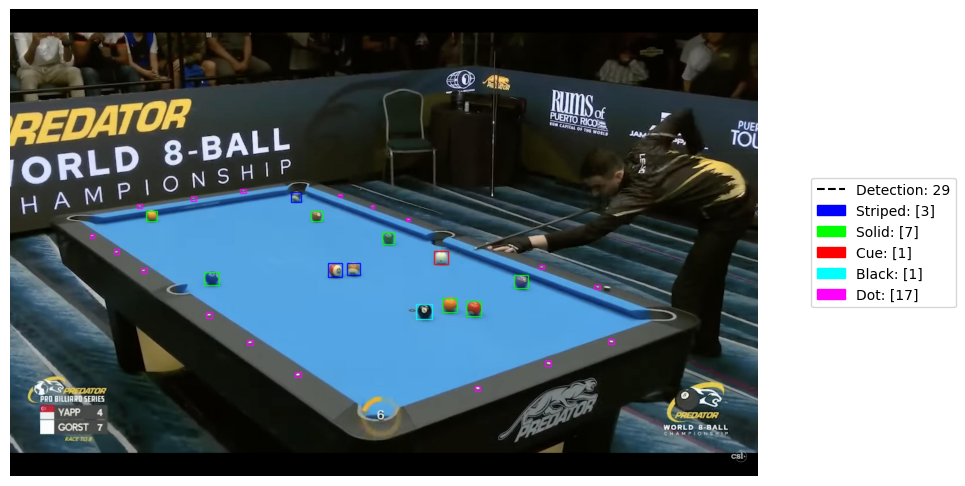

In [8]:
%matplotlib inline

# plot detections
plot_bboxes(image, None, detections,save_path=save_folder / f'plot_bboxes.png')

#### Create mapping from image to table

In [9]:
%matplotlib inline
# Use HomographyMapping to extract lines and convert to RL environment format

# TODO: check angleratio use
Object = HomographyMapping(detections=detections,
                           im=image,
                           savepath=save_folder)

Some dots are not visible, using only corners for mapping
ratios: 2562.17 3471.90 0.7380
viewtype: 45VIEW


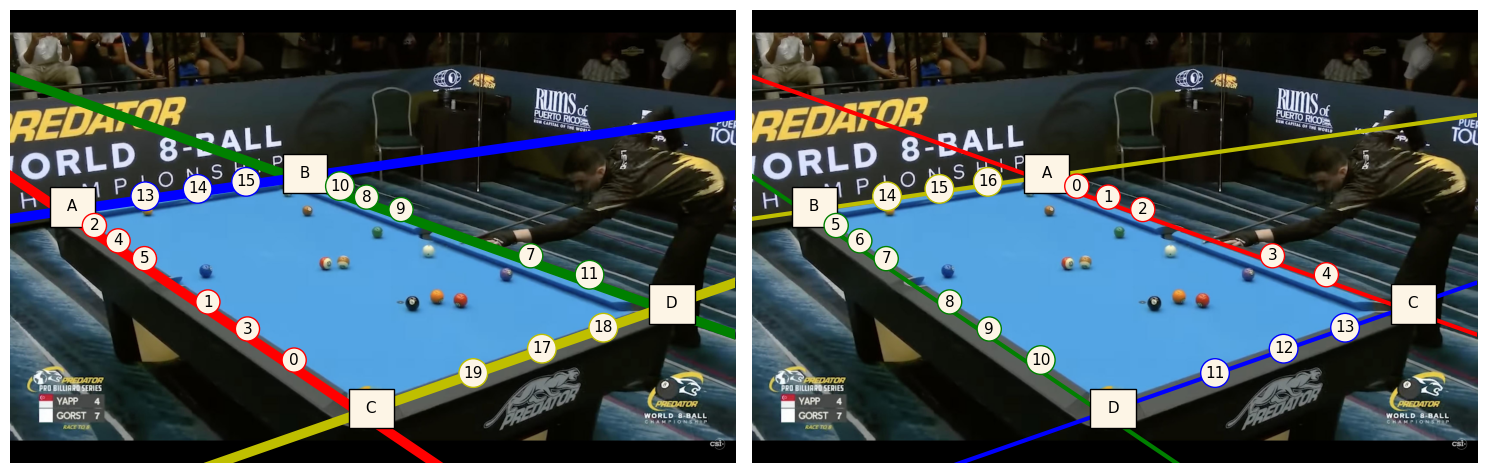

In [10]:
#plot table sides and correction of sorting
Object.plot_lines(save=True)

In [13]:
# plot template mapping
# Object.plot_template(save=True)

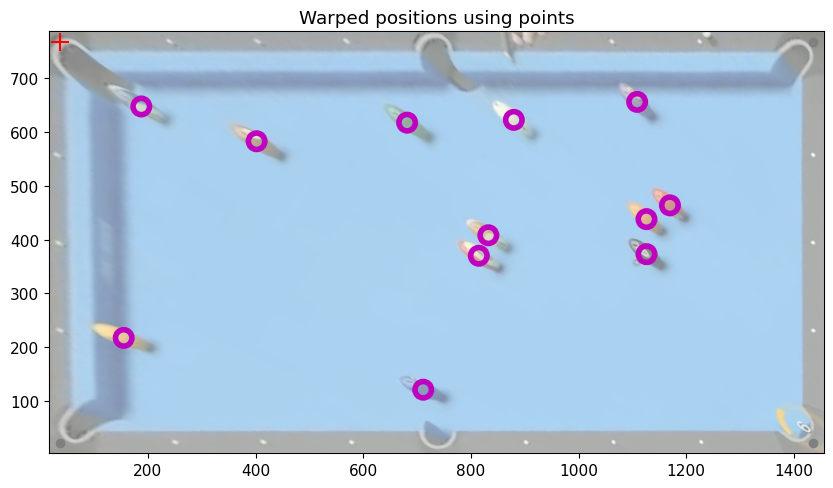

In [12]:
# plot the warped ball positions on warped image (image look disturbed, but is only for reference)
Object.plot_warped()

#### Run Doublecam experiment

Some dots are not visible, using only corners for mapping
ratios: 2657.97 4985.35 0.5332
viewtype: TOPVIEW
Found balls in topview image


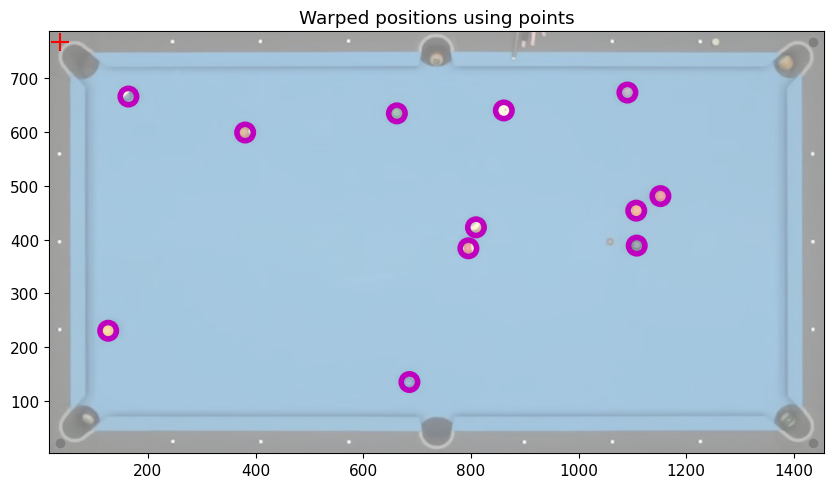

Shift between topview balls and projected balls from 45VIEW


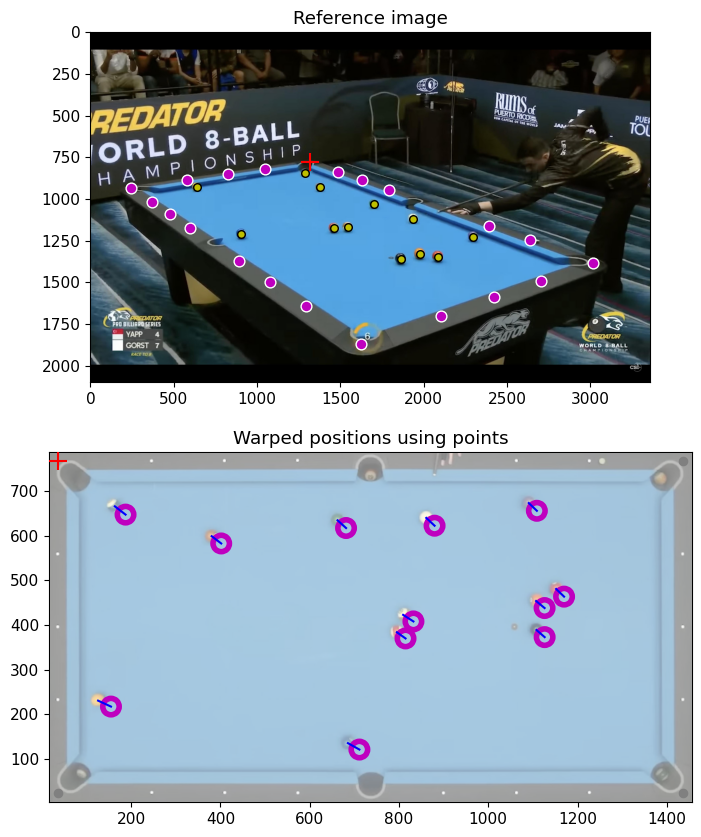

In [14]:
# compare image 1 to topview (image 2)
if doublecam:
    datanum_compare = datanum + 1
    im_path_compare = im_paths[datanum_compare]
    label_path_compare = label_paths[datanum_compare]

    image_compare, detections_compare = get_detection(im_path=im_path_compare, model=detection_model, post_process=True)

    # plot_bboxes(image_compare, None, detections_compare,
    #             save_path=save_folder / f'plot_bboxes.png')
    
    Object_compare = HomographyMapping(detections=detections_compare,
                                       im=image_compare,
                                       savepath=save_folder)

    # r = radius from pocket center to remove pocketed balls
    mask = Object_compare.remove_pocketed_balls(r=100)

    print('='*100,'\nFound balls in topview image')
    Object_compare.plot_warped()

    print('='*100,f'\nShift between topview balls and projected balls from {Object.viewtype}')
    Object.plot_compare2topview(Object_compare)

#### Get RL prediction

In [15]:
# RL_model_path = 'RL_models/PPO.zip'
RL_model_path = 'Oracle'
RL_model = load_RL_no_env(RL_model_path)

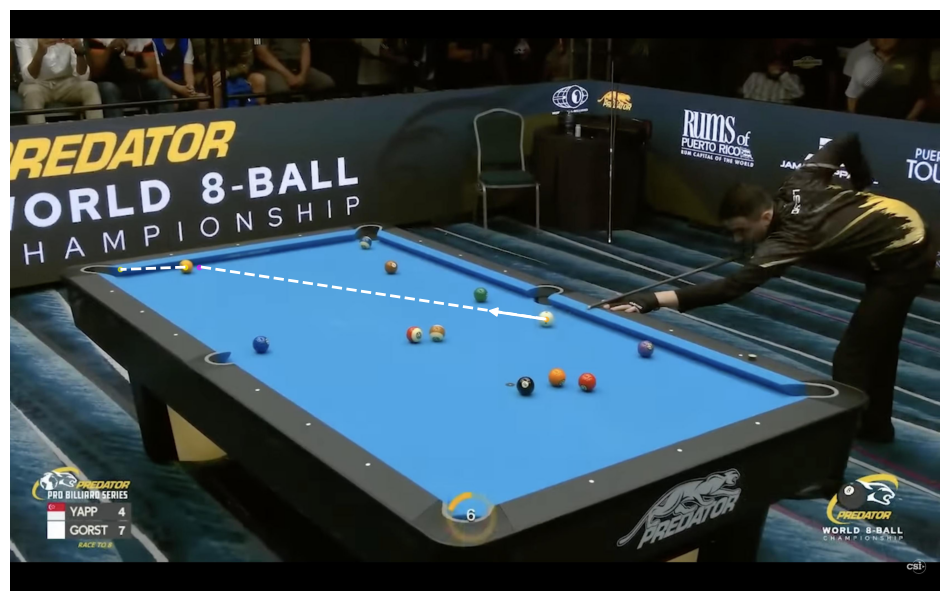

In [18]:
Object.RL_predict(RL_model) # needs to be called before plot_RL_arrow
Object.plot_RL_arrow(save=False,plot_warped=False)

### Run Simulation of Pool Environment

In [17]:
import gymnasium as gym

from auxillary.RL_Pool_env3 import PoolEnv
import auxillary.RL_config_env as cfg
from auxillary.RL_functions import run_model, load_RL_model

from auxillary.RL_custom_evaluate_policy import custom_evaluate_policy
from auxillary.RL_custom_evaluate_policy import custom_evaluate_policy_masked

from stable_baselines3 import PPO, TD3, A2C, DDPG, SAC
from stable_baselines3.common.env_util import make_vec_env

from sb3_contrib.common.maskable.policies import MaskableActorCriticPolicy
from sb3_contrib.common.wrappers import ActionMasker
from sb3_contrib.ppo_mask import MaskablePPO

In [18]:
# Setup
ALGO = "PPO"  # PPO_masked  TD3  PPO  SAC DDPG A2C
ORACLE = False  # Enable Oracle if true
nb = 16  # Number of balls.
max_num_shots = 10  # Number of shots before a state resets if no game ending criteria has been met

# Load learned states
assert nb == 1 or nb == 2 or nb == 16
if nb == 2: ls = np.load("1_000_000_states.npy")
elif nb == 16: ls = np.load("1_000_000_states_full_table.npy")
else: ls = None

# ls = np.load('rl_balls.npy')
ls = Object.to_RL()
# Try with image above
# ls = detections[detections[:, -1] != 4][:, [0, 1, -1]]  # Get only ball detections and keep only x,y and class values

env_kwargs = dict(
    algo=ALGO,
    balls_init=ls,
    suit=2,
    training=False,
    fps=60,  # 60
    num_balls=nb,
    special_state=None,  # 497852  666
    obs_type='vector',
    sigma=0,
    oracle=ORACLE,
    game_type='normal',  # 'blue_only' or 'normal'
    bank_shots=False,
    max_num_shots=10
)

use_masking = True if ALGO == 'PPO_masked' else False

In [19]:
RL_model, env = load_RL_model(ALGO, env_kwargs)
run_model(RL_model, env, max_steps=100, render=True, use_masking=use_masking)

# This cell will open a pygame window.
# When this window is closed, an error will show, which is perfectly normal.

Using PPO algorithm
------------------------------



--------------------------------------------------
Action                    Angle:   -5.94
                          Force:  500.00

- reward off
hit_suit                  10.00 
hit_suit                  10.00 
hit_suit                  10.00 
hit_suit                  10.00 
- reward off
target_angle_pocket       -3.86 with spec:  11.67 
--------------------------------------------------
Total Reward              36.14
Total Reward (normalized):     0.1721
--------------------------------------------------




--------------------------------------------------
Action                    Angle:   -5.94
                          Force:  500.00

- reward off
hit_suit                  10.00 
hit_suit                  10.00 
hit_suit                  10.00 
hit_suit                  10.00 
- reward off
target_angle_pocket       26.77 with spec:  3.03 
--------------------------------------------------
Total Reward              66.77
To

SystemExit: 